In [22]:
from langchain_experimental.sql import SQLDatabaseChain
from langchain import OpenAI
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, text
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
import os

# Using t5-small-finetuned-wikiSQL

In [74]:
# Load a pre-trained text-to-SQL model
model_name = "mrm8488/t5-small-finetuned-wikiSQL"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [8]:
# Create an SQLite database and an employees table for the example
engine = create_engine('sqlite:///example.db')
metadata = MetaData()

employees = Table('employees', metadata,
                  Column('id', Integer, primary_key=True),
                  Column('name', String),
                  Column('salary', Integer))

# Create the table in the database
metadata.create_all(engine)

In [18]:
# Insert example data
with engine.connect() as conn:
    # Begin a transaction
    trans = conn.begin()
    try:
        conn.execute(employees.insert(), [
            {'name': 'John Doe', 'salary': 25000},
            {'name': 'Jane Smith', 'salary': 18000},
            {'name': 'Alice Johnson', 'salary': 22000},
            {'name': 'Mark Taylor', 'salary': 30000},
            {'name': 'Linda Green', 'salary': 15000},
            {'name': 'Michael Brown', 'salary': 27000},
            {'name': 'Emily White', 'salary': 20000},
            {'name': 'David Black', 'salary': 24000},
            {'name': 'Sophie Turner', 'salary': 21000},
            {'name': 'Chris Evans', 'salary': 23000},
        ])
        # Commit the transaction
        trans.commit()
    except:
        # Rollback the transaction in case of an error
        trans.rollback()
        raise


### Screenshot of the DB with data

![image.png](attachment:image.png)

In [77]:
#Generate SQL Query
def get_sql(query, tokenizer, model):
  input_text = "translate English to SQL: %s </s>" % query
  features = tokenizer([input_text], return_tensors='pt')

  output = model.generate(input_ids=features['input_ids'],
               attention_mask=features['attention_mask'])

  return tokenizer.decode(output[0])

# Clean generated output:
def clean_sql_output(sql_query):
    # Remove unwanted tokens like '<pad>' and '</s>'
    cleaned_query = sql_query.replace('<pad>', '').replace('</s>', '')

    # Replace the word "table" with "employees"
    cleaned_query = cleaned_query.replace('table', 'employees')

    # Remove any extra leading/trailing whitespace
    cleaned_query = cleaned_query.strip()

    return cleaned_query


In [92]:
query = "How many employees have a salary above 15000"
sql_query = clean_sql_output(get_sql(query, tokenizer, model))
print(sql_query)

SELECT COUNT Employees FROM employees WHERE Salary > 15000


# Using t5-base-finetuned-wikiSQL

In [12]:
# Load the second model (mrm8488/t5-base-finetuned-wikiSQL)
model_name_base = "mrm8488/t5-base-finetuned-wikiSQL"
tokenizer_base = AutoTokenizer.from_pretrained(model_name_base)
model_base = AutoModelForSeq2SeqLM.from_pretrained(model_name_base)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [91]:
query = "How many employees have the name John"
sql_query = clean_sql_output(get_sql(query, tokenizer_base, model_base))
print(sql_query)

SELECT COUNT Employee FROM employees WHERE Name = John


In [94]:
import time
import matplotlib.pyplot as plt

# List of natural language queries for testing
queries = [
    "How many employees earn more than 20000?",
    "Show all employees who earn less than 22000.",
    "What is the average salary of employees?",
    "Who has the highest salary?",
    "List all employee names.",
    "What is the total salary for all employees?",
    "List employees with a salary of 18000.",
    "How many employees earn less than 15000?",
    "Show employees with salaries between 20000 and 30000.",
    "Who is the employee with the lowest salary?",
    "How many employees are there?",
    "Show employees sorted by salary from highest to lowest.",
    "List employees whose names start with 'J'.",
    "What is the total of all salaries?",
    "Show employees earning 25000 or less.",
    "Find employees who earn more than the average salary.",
    "List employees and their salaries.",
    "What is the highest salary?",
    "What is the difference between the highest and lowest salaries?",
    "Show the top 3 highest-paid employees.",
    "How many employees earn an even salary?",
    "Show employees whose salary is a multiple of 5000.",
    "List employees with a salary ending in '000'.",
    "What is the median salary of employees? (Estimate by sorting)",
    "List employees who have worked for more than 5 years.",
    "Who earns the second-highest salary? (Estimate by sorting)",
    "List employees with 'John' in their name.",
    "Count employees earning at least 18000.",
    "List employees and their salaries from lowest to highest.",
    "How many different salary amounts are there?",
    "Group employees by their salary range.",
    "What is the average salary of employees whose names start with 'A'?",
    "What percent of employees earn more than 20000? (Estimate)",
    "List employees hired in the last 2 years.",
    "Who has a prime number salary? (Estimate by checking)",
    "What salary is most common among employees?",
    "List employees who have been here for 10 years.",
    "What is the average salary of employees with more than 3 years in the company?",
    "How many employees have names longer than 6 characters?",
    "Show employees with the same salary as John Doe.",
    "What is the range of salaries among employees?",
    "Find the average salary for each salary amount.",
    "List the first 5 employees by salary.",
    "What is the standard deviation of salaries? (Estimate)",
    "Show employees earning more than the average salary.",
    "Who has the same salary as others? (Estimate by grouping)",
    "How many employees earn in the top 10%? (Estimate)",
    "List employees whose names have 5 characters."
]


# Initialize results storage
results = {
    "query": [],
    "model_name": [],
    "execution_time": [],
    "sql_query": []
}

# Function to evaluate both models
def evaluate_models(queries):
    for query in queries:
        # Evaluate small model
        start_time = time.time()
        sql_query_small = get_sql(query, tokenizer, model)
        end_time = time.time()
        results["query"].append(query)
        results["model_name"].append("t5-small-finetuned-wikiSQL")
        results["execution_time"].append(end_time - start_time)
        results["sql_query"].append(clean_sql_output(sql_query_small))

        # Evaluate base model
        start_time = time.time()
        sql_query_base = get_sql(query, tokenizer_base, model_base)
        end_time = time.time()
        results["query"].append(query)
        results["model_name"].append("t5-base-finetuned-wikiSQL")
        results["execution_time"].append(end_time - start_time)
        results["sql_query"].append(clean_sql_output(sql_query_base))

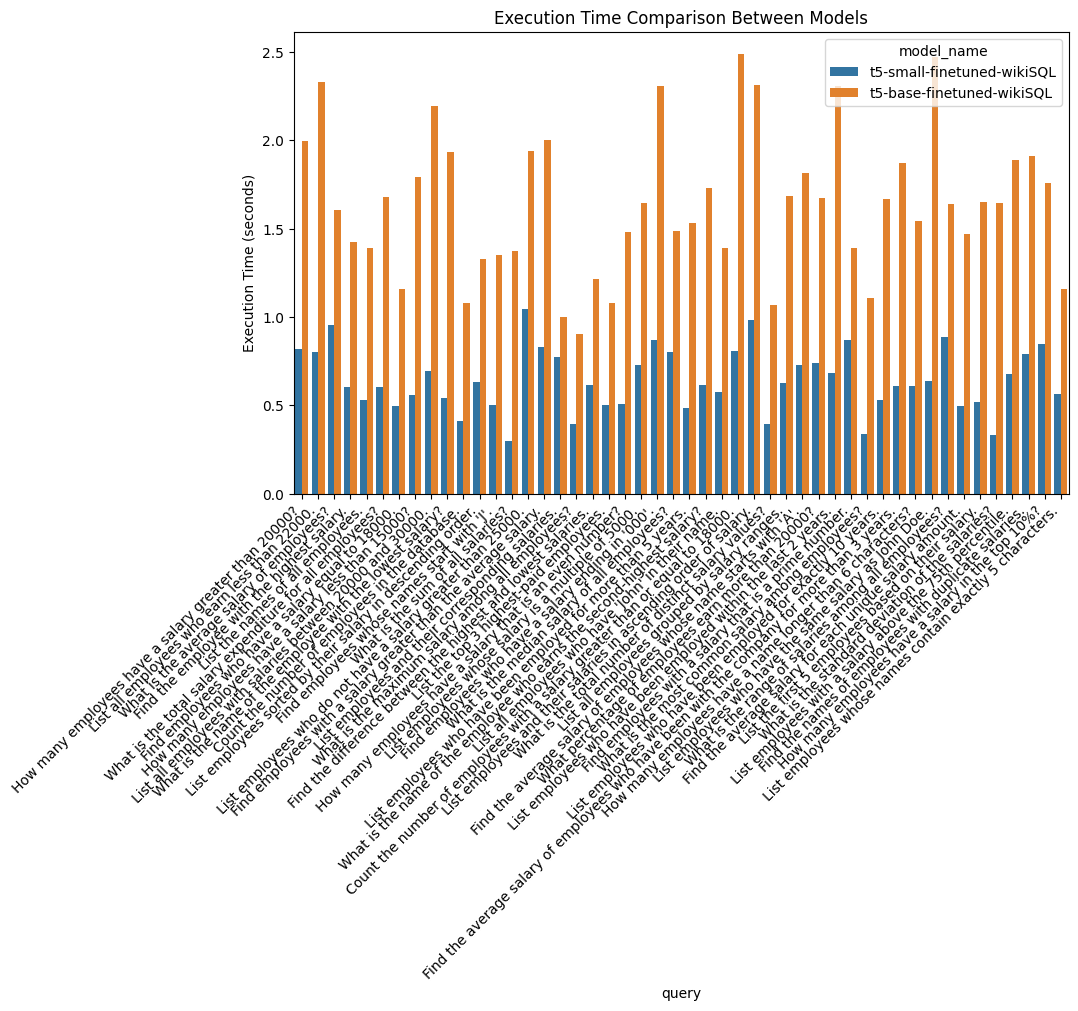

In [15]:
import seaborn as sns

# Create a DataFrame for visualization
import pandas as pd
df = pd.DataFrame(results)

# Plot execution time comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='query', y='execution_time', hue='model_name', data=df)
plt.title('Execution Time Comparison Between Models')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=45, ha="right")
plt.show()


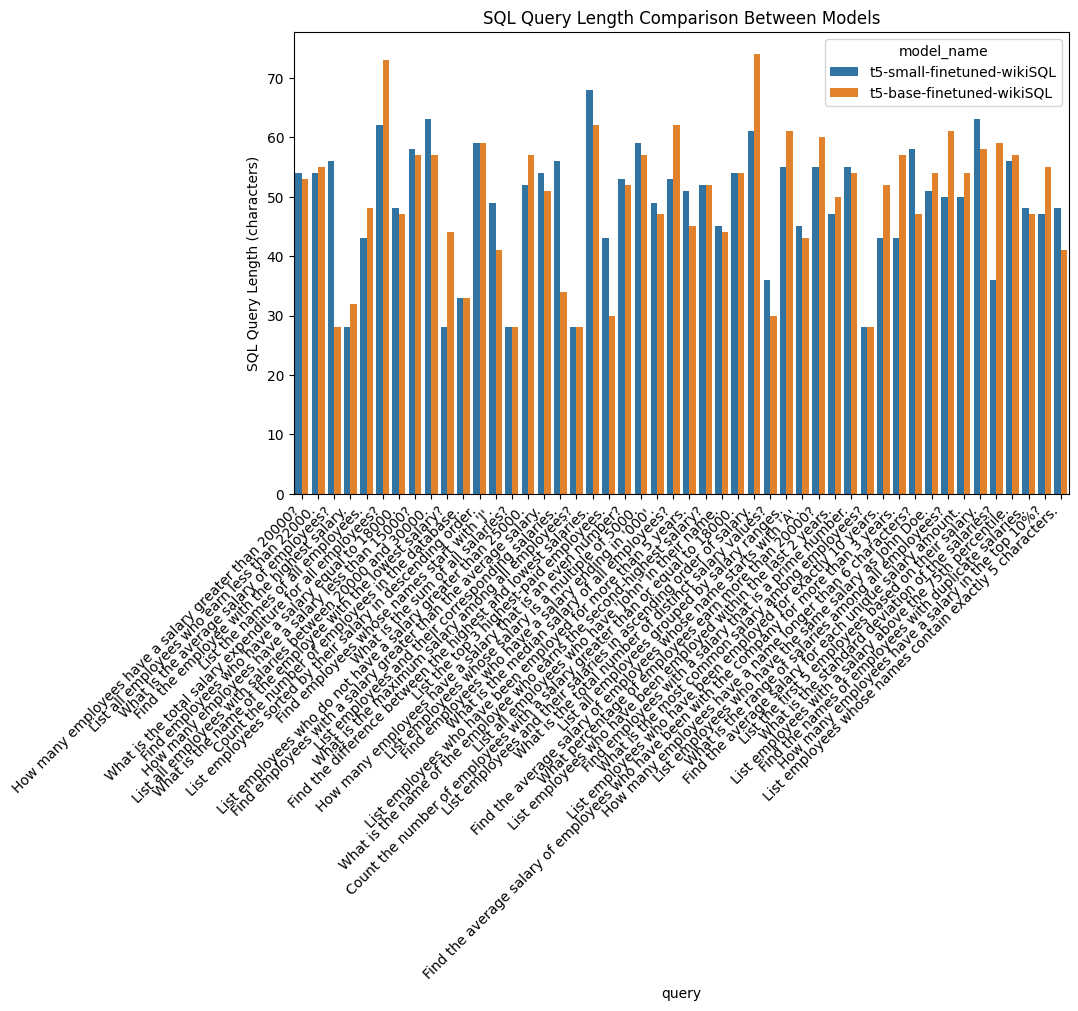

In [16]:
# Add a column for SQL query length
df['sql_length'] = df['sql_query'].apply(len)

# Plot SQL query length comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='query', y='sql_length', hue='model_name', data=df)
plt.title('SQL Query Length Comparison Between Models')
plt.ylabel('SQL Query Length (characters)')
plt.xticks(rotation=45, ha="right")
plt.show()


In [17]:
# Calculate and print numerical metrics
avg_exec_time_small = df[df['model_name'] == "t5-small-finetuned-wikiSQL"]['execution_time'].mean()
avg_exec_time_base = df[df['model_name'] == "t5-base-finetuned-wikiSQL"]['execution_time'].mean()

avg_sql_length_small = df[df['model_name'] == "t5-small-finetuned-wikiSQL"]['sql_length'].mean()
avg_sql_length_base = df[df['model_name'] == "t5-base-finetuned-wikiSQL"]['sql_length'].mean()

print("Numerical Metrics:")
print(f"Average Execution Time (t5-small): {avg_exec_time_small:.4f} seconds")
print(f"Average Execution Time (t5-base): {avg_exec_time_base:.4f} seconds")
print(f"Average SQL Query Length (t5-small): {avg_sql_length_small:.2f} characters")
print(f"Average SQL Query Length (t5-base): {avg_sql_length_base:.2f} characters")

Numerical Metrics:
Average Execution Time (t5-small): 0.6435 seconds
Average Execution Time (t5-base): 1.6431 seconds
Average SQL Query Length (t5-small): 49.06 characters
Average SQL Query Length (t5-base): 49.42 characters


In [84]:
import numpy as np
from difflib import SequenceMatcher

# Function to calculate similarity score
def calculate_similarity(expected, generated):
    return SequenceMatcher(None, expected, generated).ratio()

def evaluate_queries(queries, expected_queries):
    results = []

    for query, expected in zip(queries, expected_queries):
        # Generate SQL queries using both models
        sql_query_small = clean_sql_output(get_sql(query, tokenizer, model))
        sql_query_base = clean_sql_output(get_sql(query, tokenizer_base, model_base))

        # Calculate similarity scores
        similarity_small = calculate_similarity(expected, sql_query_small)
        similarity_base = calculate_similarity(expected, sql_query_base)
        similarity_expected = calculate_similarity(expected, expected)  # This will always be 1

        results.append({
            "query": query,
            "expected": expected,
            "generated_small": sql_query_small,
            "generated_base": sql_query_base,
            "similarity_small": similarity_small,
            "similarity_base": similarity_base,
            "similarity_expected": similarity_expected  # Always 1
        })

    return results

def visualize_similarity(results):
    df = pd.DataFrame(results)

    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(df))

    # Bar for the small model
    plt.bar(index, df['similarity_small'], bar_width, label='Small Model', color='skyblue')

    # Bar for the base model, slightly offset to the right
    plt.bar(index + bar_width, df['similarity_base'], bar_width, label='Base Model', color='salmon')

    # Bar for expected queries, slightly offset to the right
    plt.bar(index + 2 * bar_width, df['similarity_expected'], bar_width, label='Expected Query', color='lightgreen')

    plt.axhline(y=0.8, color='red', linestyle='--', label='Threshold (0.8)')
    plt.xlabel('Queries')
    plt.ylabel('Similarity Score')
    plt.title('Comparison of Similarity Scores of Generated SQL Queries')
    plt.xticks(index + bar_width, df['query'], rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def calculate_average_similarity(results):
    df = pd.DataFrame(results)
    average_small = df['similarity_small'].mean()
    average_base = df['similarity_base'].mean()

    return average_small, average_base

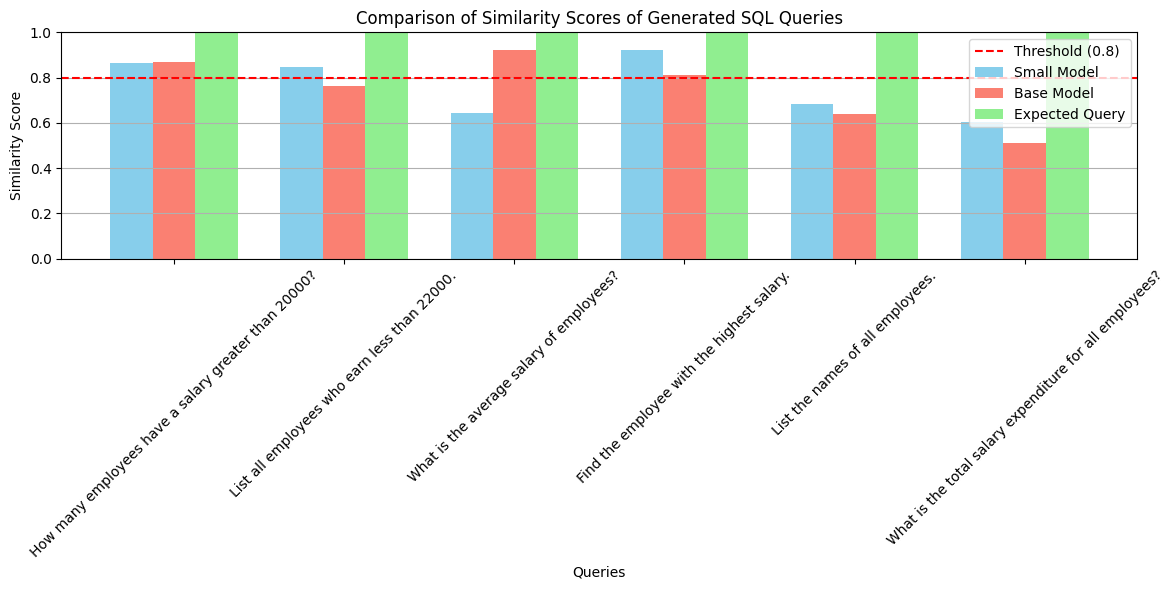

Average Similarity Score - Small Model: 0.76
Average Similarity Score - Base Model: 0.75


In [96]:
# Example usage
test_queries = [
    "How many employees have a salary greater than 20000?",
    "List all employees who earn less than 22000.",
    "What is the average salary of employees?",
    "Find the employee with the highest salary.",
    "List the names of all employees.",
    "What is the total salary expenditure for all employees?"
]

expected_test_queries = [
    "SELECT COUNT(*) FROM employees WHERE salary > 20000",
    "SELECT * FROM employees WHERE earnings < 22000",
    "SELECT AVG(salary) FROM employees",
    "SELECT MAX(salary) FROM employees",
    "SELECT name FROM employees",
    "SELECT SUM(salary) FROM employees"
]

test_results = evaluate_queries(test_queries, expected_test_queries)

# Visualize the similarity scores
visualize_similarity(test_results)

# Calculate and print average similarity scores
avg_small, avg_base = calculate_average_similarity(test_results)
print(f"Average Similarity Score - Small Model: {avg_small:.2f}")
print(f"Average Similarity Score - Base Model: {avg_base:.2f}")